# Lab 5: Regression and Dimensionality Reduction

#### Name:  Paul Trayers
#### Student ID:  8907021

# Task 1
----
## 1. Load Data

The objective of this exercise is to develop a regression model that can predict the cost of insurance cost for an individual based on characteristics of the person.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("./insurance.csv")

# Task 2
----

## 2.1 EDA

Check for missing values and outliers.

In [3]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [4]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

Identifying categorical and numerical columns.

In [5]:
# Select categorical columns
categorical_cols = list(df.select_dtypes(include=['object']).columns)
# Select numerical columns
numerical_cols = list(df.select_dtypes(exclude=['object']).columns)

print(f"Categorical fields: {categorical_cols}")
print(f"Numerical fields: {numerical_cols}")

Categorical fields: ['gender', 'smoker', 'region']
Numerical fields: ['age', 'bmi', 'children', 'insurance_cost']


Let's examine values in the categorical columns first.

In [6]:
# iterate categorical columns
for col in categorical_cols:  
    print(f"\nFeature: {col}")
    print(df[col].value_counts())


Feature: gender
male      676
female    662
Name: gender, dtype: int64

Feature: smoker
no     1064
yes     274
Name: smoker, dtype: int64

Feature: region
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


`gender` and `smoker` are well balanced, `smoker` is imbalanced with non-smokers outnumbering smokers by a factor of 4.

Check for missing values...

In [7]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes...

In [8]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

The summary statistics count values suggest no missing values in numerical columns and range of values in each column appears reasonable with min, max and quartiles within expected bounds.

Next, let's check for outliers in the numerical columns. Based on the table above we can try to plot all numerical column except `insurance_cost` together.

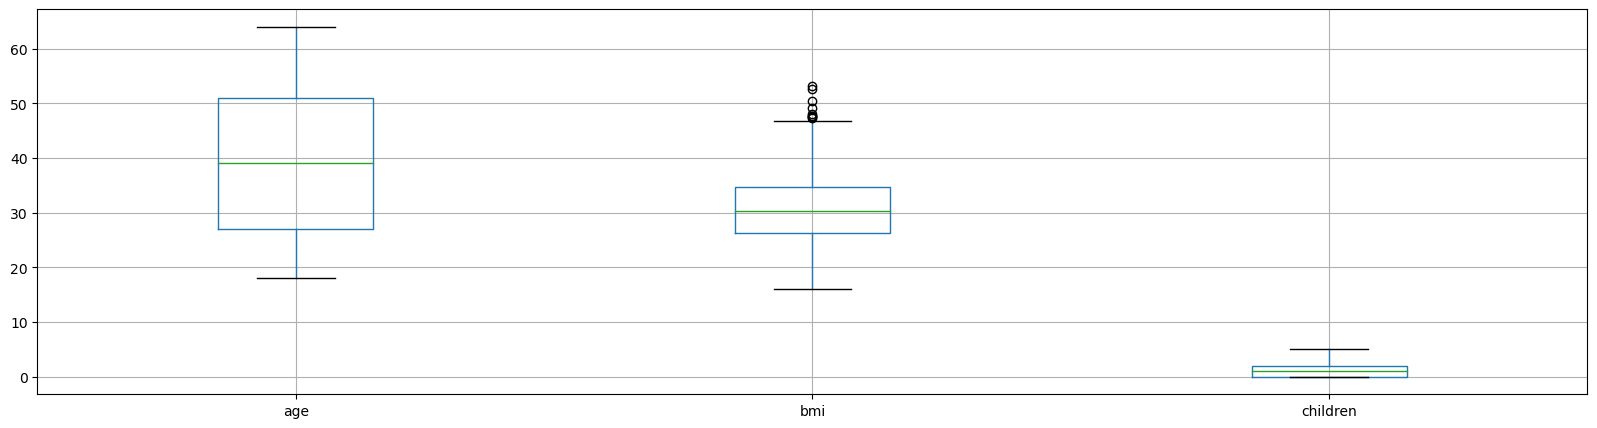

In [9]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

* The bmi attribute contains some outliers, although they are still may be plausible.  To be prudent, we will apply a RobustScaler and then a log transform to the bmi data.
* The other attributes do not have outliers, so we apply a StandardScaler to rescale these attributes.

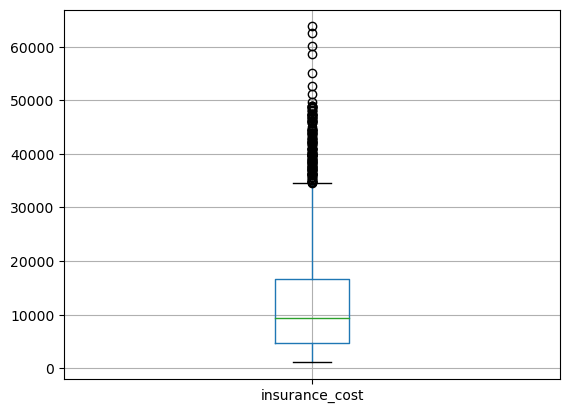

In [10]:
df.boxplot(column=['insurance_cost'])
plt.show()

The examples shown as outliers could be considered acceptable since insurance costs can vary widely depending on individual circumstances. For example much higher insurance_costs may well be associated with the higher mortality risk of smokers with high BMI.

Next we visualise the distributions...

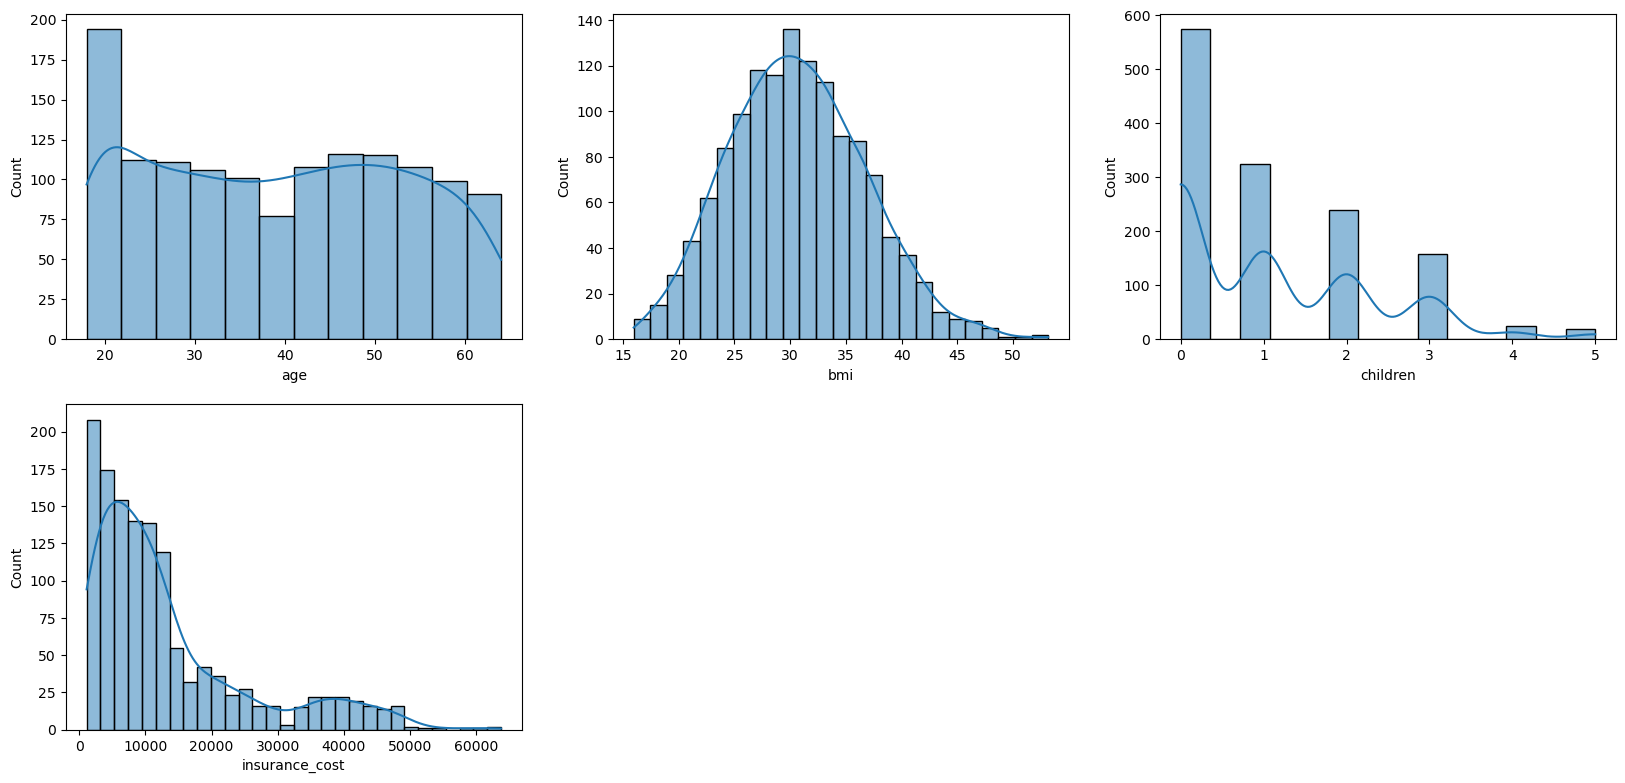

In [11]:
import seaborn as sns

plt.figure(figsize=(20,60), facecolor='white')

plotnumber = 1
for col in numerical_cols:
    ax = plt.subplot(12,3,plotnumber)
    sns.histplot(df[col], kde=True)

    plt.xlabel(col)
    plotnumber += 1

## 2.2 Data Preparation

### 2.2.1 Categorical Features

We replace categorical columns `gender`, `smoker`, `region` by multiple numerical columns. Since the values of these fields do not have order, we will use `one-hot encoding` to do this. 

In [12]:
df = pd.get_dummies(df, columns=['gender', 'smoker', 'region'], 
                        #dummy_na=True,  # no missing values in this dataset
                        drop_first=True)

Examine the transformed dataset...

In [13]:
df.head()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
0   18  33.770         1      1725.55230            1           0   
1   18  34.100         0      1137.01100            1           0   
2   18  26.315         0      2198.18985            0           0   
3   18  38.665         2      3393.35635            0           0   
4   18  35.625         0      2211.13075            0           0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 0                 1                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0

In [14]:
df.tail()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
1333   64  31.825         2     16069.08475            0           0   
1334   64  26.885         0     29330.98315            0           1   
1335   64  26.410         0     14394.55790            1           0   
1336   64  36.960         2     49577.66240            1           1   
1337   64  23.760         0     26926.51440            1           1   

      region_northwest  region_southeast  region_southwest  
1333                 0                 0                 0  
1334                 1                 0                 0  
1335                 0                 0                 0  
1336                 0                 1                 0  
1337                 0                 1                 0

### 2.2.2 Numerical Features

Apply the transformations to outlier column `bmi` mentioned above (Log transformation followed by `RobustScaler`) and `StandardScaler` to all other columns.

In [15]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['insurance_cost']]

# group columns based on data preparation requirements
names_outliers = ['bmi']
names_no_outliers = list(set(names_all) - set(names_outliers))

Create pipeline for preprocessing...

In [16]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Create pipeline to apply different preprocessing techniques to handle columns with and without outliers. Combine results of multiple transformer objects, which are applied to different subsets of the dataset's features.


In [17]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

(Try below applying to outlier treatment as alternative for comparison)

In [18]:
# Since there are no significant outliers, we will apply `StandardScaler` to all predictor columns with a simple pre-processing pipeline.

# preprocess_pipeline = make_pipeline(StandardScaler())

# @TBC - try this simplistic approach for comparison with the above.

Now we separate columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [19]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## 2.3 Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care of separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### 2.3.1 Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [20]:
rf_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', RandomForestRegressor(n_estimators=10))])  # n_estimators specifies number of trees in the forest.

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

The RFE feature selection method iteratively removes the least important features based on the performance of a given estimator (in this case, either svm.SVR or LinearRegression). We should note that the regression algorithms used for feature selection in RFE don't have to be the same as the final regression algorithm used in the main pipeline. The role of the algorithms in RFE is to help identify the most important features, once the feature set is reduced, any regression algorithm can be used in the main pipeline to make predictions based on the selected features.

In [21]:
# Perform a grid search with cross-validation for a random forest regression model using different dimensionality reduction techniques and hyperparameters. 

N_FEATURES_OPTIONS = [2, 5, 8]
N_COMPONENTS_OPTIONS = [2, 5, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

# dictionary of seperate search spaces for grid search
rf_param_grid = [
    {
        # PCA dimensionality reduction
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS, # number of components to keep
        'regression__max_depth': MAX_DEPTH_OPTIONS   # max depth of each tree in the forest
    },
    {
        # Recursive feature elimination (RFE) dimensionality reduction with two different estimators
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),
                       RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    }  
]

rf_search = GridSearchCV(rf_pipe, 
                         rf_param_grid,  # explore the different search spaces 
                         n_jobs=-1, 
                         cv=5, 
                         refit=True)     # refit the best model with the entire dataset
rf_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % rf_search.best_score_)
print("Best parameters: ", rf_search.best_params_)

# store the best params and best model for later use
RF_best_params = rf_search.best_params_
RF_best_model = rf_search.best_estimator_

Best CV score = 0.842:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5, 'regression__max_depth': 4}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

### 2.3.2 Linear Regression Pipeline

In [22]:
lr_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                        ('reduce_dim', 'passthrough'),
                        ('regression', LinearRegression())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [23]:
N_FEATURES_OPTIONS = [2, 5, 8]   # features to use in RFE
N_COMPONENTS_OPTIONS = [2, 5, 8] # components to keep in PCA
#NORMALIZE_OPTIONS = [False, True] omit as deprecated in sklearn

lr_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS#,
        #'regression__normalize': NORMALIZE_OPTIONS  # deprecated in sklearn
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),
                       RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS#,
        #'regression__normalize': NORMALIZE_OPTIONS, # deprecated in sklearn
    }  
]

lr_search = GridSearchCV(lr_pipe, 
                         lr_param_grid, # explore the different search spaces 
                         n_jobs=-1,  # parallel processing 
                         cv=5,       # 10-fold would be more accurate but slower
                         refit=True) # refit the best model with the entire dataset
lr_search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % lr_search.best_score_)
print("Best parameters: ", lr_search.best_params_)

# store the best params and best model for later use
LR_best_params = lr_search.best_params_
LR_best_model = lr_search.best_estimator_

Best CV score = 0.730:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5}


### 2.3.3 SVR Regression Pipeline

Create and run SVM regression (SVR) pipeline with the same dimensionality reduction techniques as previous models...

In [47]:
N_COMPONENTS_OPTIONS = [2, 5, 8]
NORMALIZE_OPTIONS = [False, True]

# create the pipeline
svm_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                           ('reduce_dim', 'passthrough'),
                           ('svm', svm.SVR(kernel='linear', gamma='auto'))])

# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

svm_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS#,
        #'regression__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(
                           kernel='linear', 
                           gamma='auto')),
                       RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS#,
        #'regression__normalize': NORMALIZE_OPTIONS
    }  
]

svm_search = GridSearchCV(svm_pipe,
                      svm_param_grid,
                      n_jobs=-1,  # use multiple cores if available
                      cv=5,       # k-fold cross-validation 
                      refit=True) # makes GridSearchCV train an SVM classifier on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.
svm_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % svm_search.best_score_)
print("Best parameters: ", svm_search.best_params_)

# store the best params and best model for later use
SVM_best_params = svm_search.best_params_
SVM_best_model = svm_search.best_estimator_

Best CV score = -0.035:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8}


### 2.3.4 MLP Regression Pipeline
Create and run a Multi-Layer Perceptron (MLP) regression pipeline with the same dimensionality reduction techniques as previous models...

In [ ]:
import warnings   # supress sklearn convergence warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

N_FEATURES_OPTIONS = [2, 5, 8]
N_COMPONENTS_OPTIONS = [2, 5, 8]
NORMALIZE_OPTIONS = [False, True]

# create the pipeline
mlp_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                           ('normalize', 'passthrough'),
                           ('reduce_dim', 'passthrough'),
                           ('mlp', MLPRegressor())])

# prepare a parameter grid
mlp_param_grid = [
    {
        'normalize': [None, StandardScaler()],
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS,
        'mlp__hidden_layer_sizes': [(50,), (100,), (50,50)],
        #'mlp__activation': ['relu', 'tanh'],
        #'mlp__alpha': [0.0001, 0.001, 0.01],
        'mlp__max_iter': [1000],   # [100, 200, 300, 400]  # increasing to attempt convergence
        #'mlp__learning_rate_init': [0.001, 0.01, 0.1]
    },
    {
        'normalize': [None, StandardScaler()],
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'mlp__hidden_layer_sizes': [(50,), (100,), (50,50)],
        #'mlp__activation': ['relu', 'tanh'],
        #'mlp__alpha': [0.0001, 0.001, 0.01],
        'mlp__max_iter': [1000],   # [100, 200, 300, 400]  # increasing to attempt convergence
        #'mlp__learning_rate_init': [0.001, 0.01, 0.1]
    }  
]

mlp_search = GridSearchCV(mlp_pipe, mlp_param_grid, n_jobs=-1, cv=5, refit=True)
# Filter out convergence warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    mlp_search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % mlp_search.best_score_)
print("Best parameters: ", mlp_search.best_params_)

# store the best params and best model for later use
MLP_best_params = mlp_search.best_params_
MLP_best_model = mlp_search.best_estimator_


The results suggest that Random Forest performs best. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

## 2.4 Compare Regression Models on Test Set

Now we evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

### 2.4.1 Measure Metrics
Create function to execute multiple runs and record average metrics...

In [26]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

Execute the model multiple time $(n)$ to obtain more stable average metrics...

In [27]:
def execute_model(model, X, y, name, num_runs=10):

    # Initialize the lists to store the evaluation metrics for each run
    mse_list = []
    mae_list = []
    r2_list = []

    best_model = None
    best_score = -np.inf
    best_params = None

    for i in range(num_runs):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

        model.fit(X_train, y_train) 
        
        score = model.best_score_
        if score > best_score:
            best_params = model.best_params_
            best_score = score
            best_model = model.best_estimator_

        mse, mae, r2 = evaluate_model(X_test, y_test, model.best_estimator_)

        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)
        
    print("\nBest CV score = %0.3f:" % model.best_score_)
    print("Best parameters: ", model.best_params_)

    avg_mse = np.mean(mse_list)
    avg_mae = np.mean(mae_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average", name, f" MSE: {avg_mse:.3f}")
    print(f"Average", name, f" MAE: {avg_mae:.3f}")
    print(f"Average", name, f" R2: {avg_r2:.3f}")

    return avg_mse, avg_mae, avg_r2, best_params

We will first use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search as required by Task 2.

In [28]:
n_times = 10

RF_mse, RF_mae, RF_r2, RF_best_params = execute_model(rf_search, X, y, "RF", n_times)
LR_mse, LR_mae, LR_r2, LR_best_params = execute_model(lr_search, X, y, "LR", n_times)


Best CV score = 0.852:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'regression__max_depth': 4}
Average RF  MSE: 16832033.660
Average RF  MAE: 2384.640
Average RF  R2: 0.881

Best CV score = 0.748:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5}
Average LR  MSE: 36168023.064
Average LR  MAE: 4377.614
Average LR  R2: 0.744


Now evaluate metrics for the additional models, being SVM and MLP...

In [29]:
SVM_mse, SVM_mae, SVM_r2, SVM_best_params = execute_model(svm_search, X, y, "SVM", n_times)


Best CV score = -0.033:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5}
Average SVM  MSE: 142679340.446
Average SVM  MAE: 7681.434
Average SVM  R2: -0.010


In [ ]:
MLP_mse, MLP_mae, MLP_r2, MLP_best_params = execute_model(mlp_search, X, y, "MLP", 1)

### 2.4.2 Evaluate Metrics
Print metrics average scores...

In [31]:
from tabulate import tabulate

headers = ['Model', 'MSE', 'MAE', 'R2']
data = [
    ['Random Forest', f'{RF_mse:.3f}', f'{RF_mae:.3f}', f'{RF_r2:.3f}'],
    ['Linear Regression', f'{LR_mse:.3f}', f'{LR_mae:.3f}', f'{LR_r2:.3f}'],
    ['SVM', f'{SVM_mse:.3f}', f'{SVM_mae:.3f}', f'{SVM_r2:.3f}'],
    ['MLP', f'{MLP_mse:.3f}', f'{MLP_mae:.3f}', f'{MLP_r2:.3f}']
]
print(f"Mean results from {n_times} runs:\n")
print(tabulate(data, headers=headers))

Mean results from 10 runs:

Model                      MSE      MAE      R2
-----------------  -----------  -------  ------
Random Forest      1.6832e+07   2384.64   0.881
Linear Regression  3.6168e+07   4377.61   0.744
SVM                1.42679e+08  7681.43  -0.01
MLP                2.45796e+07  3302.08   0.826


Print dimension reduction algorithms and their parameters (direct from the objects)...

In [32]:
print(RF_best_params)
print(LR_best_params)
print(SVM_best_params)
print(MLP_best_params)

{'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'regression__max_depth': 4}
{'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5}
{'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5}
{'mlp__hidden_layer_sizes': (50, 50), 'mlp__max_iter': 1000, 'normalize': StandardScaler(), 'reduce_dim': PCA(iterated_power=7, n_components=8), 'reduce_dim__n_components': 8}


Here is same information in a tabluar format below provides an overview for the best models the dimension reduction technique and parameters selected...

In [51]:
headers = ['Model', 'Dimension Reduction', 'Components', 'Other Parameters']

data = [
    ['Random Forest', type(RF_best_params['reduce_dim']).__name__, RF_best_params['reduce_dim__n_features_to_select'], 'Max depth: {}'.format(RF_best_params['regression__max_depth'])],
    ['Linear Regression', type(LR_best_params['reduce_dim']).__name__, LR_best_params['reduce_dim__n_features_to_select'], ''],
    ['SVM', type(SVM_best_params['reduce_dim']).__name__, SVM_best_params['reduce_dim__n_features_to_select'], ''],
    ['MLP', type(MLP_best_params['reduce_dim']).__name__, MLP_best_params['reduce_dim__n_components'], 'Hidden layers: {}, Max iterations: {}'.format(MLP_best_params['mlp__hidden_layer_sizes'], MLP_best_params['mlp__max_iter'])]
]
print(tabulate(data, headers=headers))


Model              Dimension Reduction      Components  Other Parameters
-----------------  ---------------------  ------------  ---------------------------------------------
Random Forest      RFE                               8  Max depth: 4
Linear Regression  RFE                               5
SVM                RFE                               8
MLP                PCA                               8  Hidden layers: (50, 50), Max iterations: 1000


### 2.4.3 Plot Results

Using a Pandas bar plots to compare the results. 

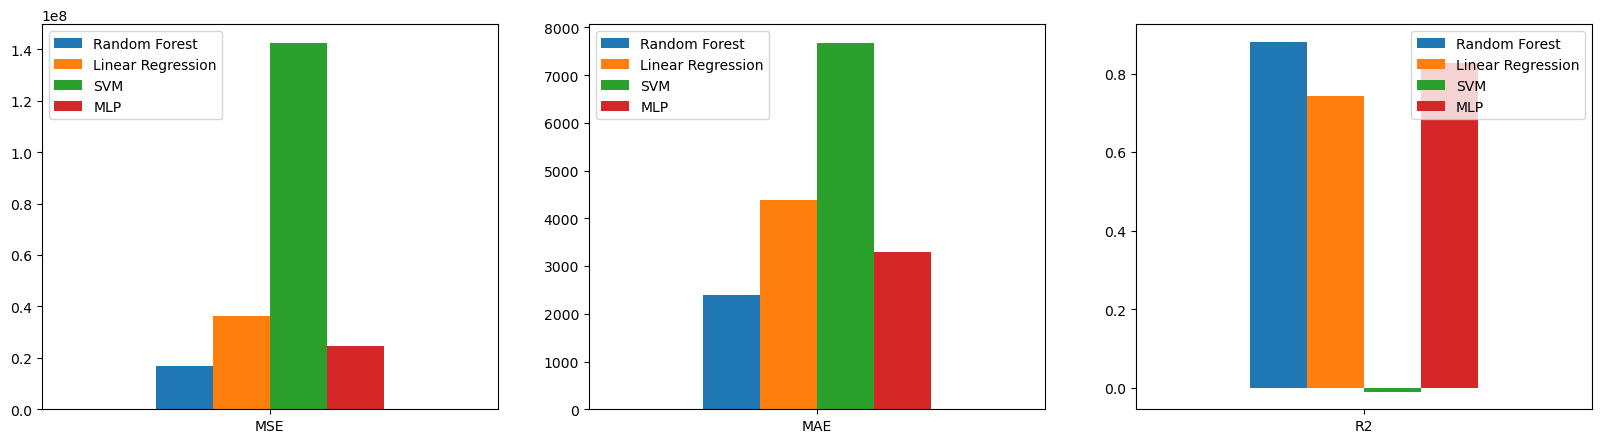

In [33]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SVM': SVM_mse, 'MLP': MLP_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SVM': SVM_mae, 'MLP': MLP_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SVM': SVM_r2, 'MLP': MLP_r2}, index=['R2'])


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

## 2.5 Train a Final Model

Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [34]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model = pipe.fit(X, y)

We can also store this model on disk.

In [35]:
filename = 'task2_final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## 2.6 Analysis and Conclusion

A summary of the performance of the models based on the results above:

Random Forest: This model outperformed all other models tested, achieving the lowest Mean Squared Error (MSE), the lowest Mean Absolute Error (MAE), and the highest R2 score. It seems to capture the underlying patterns in the data quite well and is the most suitable for this problem.

Linear Regression: As a simple model, Linear Regression performs fairly well, with an MSE, MAE, and R2 score that are relatively competitive. While it provides a good baseline, it is outperformed by the Random Forest model.

Support Vector Machine (SVM): This model performed poorly, with a high MSE, a high MAE, and negative R2 score. The results suggest that SVM is not suitable for this problem, as its predictions are worse than a simple average.

Multi-layer Perceptron (MLP): The MLP model achieved an MSE, MAE, and R2 score that were better than the Linear Regression model but still outperformed by the Random Forest model.

In conclusion, Random Forest model is the best performing model among those models tested with the lowest MSE and MAE and highest R2. To improve the results would require further feature engineering and hyperparameter tuning.

# Task 3
----

## 3.1 Train Models

This time we will retrain the models from Task 2 with different dimensionality reduction techniques;

| Algorithm              | Description                                                                                           |
|------------------------|-------------------------------------------------------------------------------------------------------|
| LocallyLinearEmbedding | Nonlinear technique preserving local geometry while transforming data to a lower-dimensional space|
| FastICA                | Independent Component Analysis: Linear technique for blind source separation and feature extraction   |
| NMF                    | Non-negative Matrix Factorization: Factorizes data into non-negative matrices for dimension reduction |
| SelectKBest            | Selects K best features based on a univariate statistical test (in this case, mutual information)     |


### 3.1.1 Random Forest
Create and run a Random Forest regression pipeline as before this time with different set of dimensionality reduction techniques...

In [59]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, mutual_info_classif

N_COMPONENTS_OPTIONS = [2, 3, 4]
N_K_OPTIONS = [2, 3, 4]
MAX_DEPTH_OPTIONS = [2, 4, 6]

rf_param_grid_task3 = [
    {
        'reduce_dim': [LocallyLinearEmbedding()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        "reduce_dim": [NMF(max_iter=1_000)],
        "reduce_dim__n_components": N_COMPONENTS_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_K_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    }
]

rf_search_task3 = GridSearchCV(rf_pipe, rf_param_grid_task3, n_jobs=-1, cv=5, refit=True)


In [ ]:
RF_mse_task3, RF_mae_task3, RF_r2_task3, RF_best_params_task3 = execute_model(rf_search_task3, X, y, "RF", 1)

### 3.1.2 Linear Regression
Create and run a Linear regression pipeline as before this time with different set of dimensionality reduction techniques...

In [63]:
N_COMPONENTS_OPTIONS = [2, 3, 4]
N_K_OPTIONS = [2, 3, 4]

lr_param_grid_task3 = [
    {
        'reduce_dim': [LocallyLinearEmbedding()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS
    },
    {
        "reduce_dim": [NMF(max_iter=1_000)],
        "reduce_dim__n_components": N_COMPONENTS_OPTIONS
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_K_OPTIONS
    }
]

lr_search_task3 = GridSearchCV(lr_pipe, lr_param_grid_task3, n_jobs=-1, cv=5, refit=True)

In [ ]:
LR_mse_task3, LR_mae_task3, LR_r2_task3, LR_best_params_task3 = execute_model(lr_search_task3, X, y, "LR", n_times)

### 3.1.3 MLP Regression
Create and run a MLP regression pipeline as before this time with different set of dimensionality reduction techniques...

In [65]:
N_COMPONENTS_OPTIONS = [2, 5, 8]
N_K_OPTIONS = [2, 3, 4]
NORMALIZE_OPTIONS = [False, True]

# prepare a parameter grid
mlp_param_grid_task3 = [
    {
        'normalize': [None, StandardScaler()],
        'reduce_dim': [LocallyLinearEmbedding()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS,
        'mlp__hidden_layer_sizes': [(50,), (100,), (50,50)],
        #'mlp__activation': ['relu', 'tanh'],
        #'mlp__alpha': [0.0001, 0.001, 0.01],
        'mlp__max_iter': [1000]   # [100, 200, 300, 400]
        #'mlp__learning_rate_init': [0.001, 0.01, 0.1]
    },
    {
        'normalize': [None, StandardScaler()],
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS,
        'mlp__hidden_layer_sizes': [(50,), (100,), (50,50)],
        #'mlp__activation': ['relu', 'tanh'],
        #'mlp__alpha': [0.0001, 0.001, 0.01],
        'mlp__max_iter': [1000]   # [100, 200, 300, 400]
        #'mlp__learning_rate_init': [0.001, 0.01, 0.1]
    },
    {
        "reduce_dim": [NMF(max_iter=1_000)],
        "reduce_dim__n_components": N_COMPONENTS_OPTIONS,
        "mlp__hidden_layer_sizes": [(50,), (100,), (50,50)],
        "mlp__max_iter": [1000]   # [100, 200, 300, 400]
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_K_OPTIONS,
        "mlp__hidden_layer_sizes": [(50,), (100,), (50,50)],
        "mlp__max_iter": [1000]   # [100, 200, 300, 400]
        
    }
]

mlp_search_task3 = GridSearchCV(mlp_pipe, mlp_param_grid_task3, n_jobs=-1, cv=5, refit=True)

In [ ]:
MLP_mse_task3, MLP_mae_task3, MLP_r2_task3, MLP_best_params_task3 = execute_model(mlp_search_task3, X, y, "MLP", n_times)

## 3.2 Compare on Test Set
Now we evaluate the best models found by the grid search on the test dataset and compare their metrics:

In [ ]:
n_times = 10

RF_mse_task3, RF_mae_task3, RF_r2_task3, RF_best_params_task3 = execute_model(rf_search_task3, X, y, "RF", n_times)
LR_mse_task3, LR_mae_task3, LR_r2_task3, LR_best_params_task3 = execute_model(lr_search_task3, X, y, "LR", n_times)
MLP_mse_task3, MLP_mae_task3, MLP_r2_task3, MLP_best_params_task3 = execute_model(mlp_search_task3, X, y, "MLP", n_times)

Print metrics average scores...

In [67]:
from tabulate import tabulate

headers = ['Model', 'MSE', 'MAE', 'R2']
data = [
    ['Random Forest', f'{RF_mse_task3:.3f}', f'{RF_mae_task3:.3f}', f'{RF_r2_task3:.3f}'],
    ['Linear Regression', f'{LR_mse_task3:.3f}', f'{LR_mae_task3:.3f}', f'{LR_r2_task3:.3f}'],
    ['MLP', f'{MLP_mse_task3:.3f}', f'{MLP_mae_task3:.3f}', f'{MLP_r2_task3:.3f}']
]
print(f"Mean results from {n_times} runs:\n")
print(tabulate(data, headers=headers))

Mean results from 10 runs:

Model                      MSE      MAE     R2
-----------------  -----------  -------  -----
Random Forest      4.53338e+07  4614.82  0.679
Linear Regression  1.00409e+08  7808.75  0.289
MLP                7.84476e+07  6799.9   0.445


Print best dimension reduction parameters found for each model..

In [68]:
headers = ['Model', 'Dimension Reduction', 'Components', 'Other Parameters']
data = [
    ['Random Forest', type(RF_best_params_task3['reduce_dim']).__name__, RF_best_params_task3['reduce_dim__n_components'], 'Max depth: {}'.format(RF_best_params_task3['regression__max_depth'])],
    ['Linear Regression', type(LR_best_params_task3['reduce_dim']).__name__, LR_best_params_task3['reduce_dim__n_components'], ''],
    ['MLP', type(MLP_best_params_task3['reduce_dim']).__name__, MLP_best_params_task3['reduce_dim__n_components'], 'Hidden layers: {}, Max iterations: {}'.format(MLP_best_params_task3['mlp__hidden_layer_sizes'], MLP_best_params_task3['mlp__max_iter'])]
]
print(tabulate(data, headers=headers))

Model              Dimension Reduction      Components  Other Parameters
-----------------  ---------------------  ------------  ---------------------------------------------
Random Forest      FastICA                           4  Max depth: 6
Linear Regression  FastICA                           4
MLP                FastICA                           8  Hidden layers: (50, 50), Max iterations: 1000


Plot results for comparison

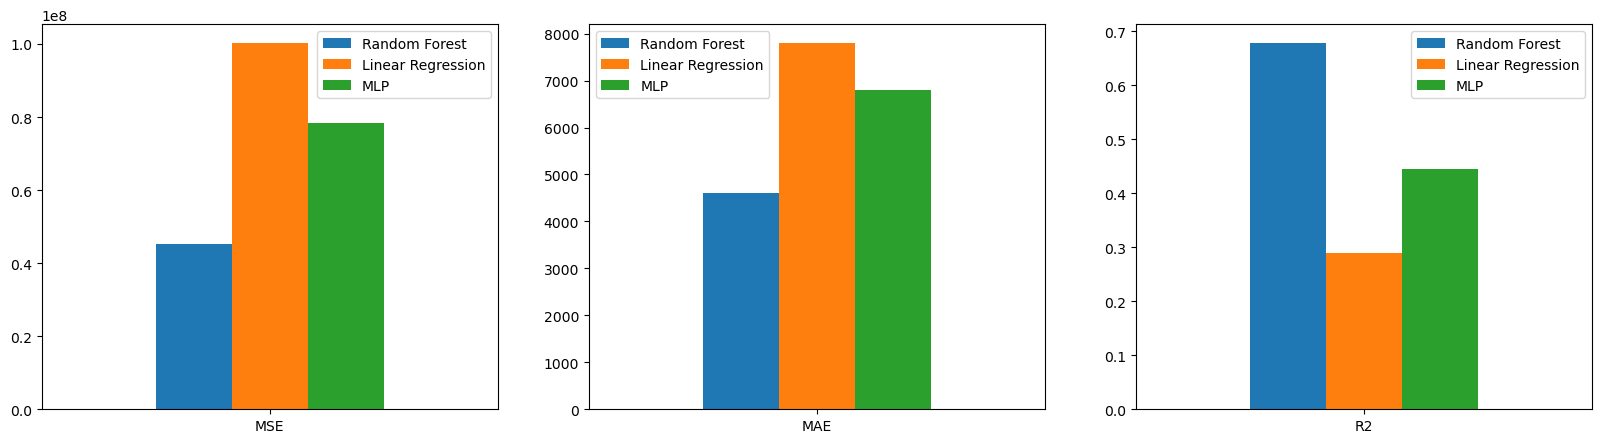

In [69]:
df_mse = pd.DataFrame({'Random Forest': RF_mse_task3, 'Linear Regression': LR_mse_task3, 'MLP': MLP_mse_task3}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae_task3, 'Linear Regression': LR_mae_task3, 'MLP': MLP_mae_task3}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2_task3, 'Linear Regression': LR_r2_task3, 'MLP': MLP_r2_task3}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

## 3.3 Analysis

### 3.3.1 Results Comparison

In Task 2, three models were trained and evaluated using mean squared error (MSE), mean absolute error (MAE), and coefficient of determination (R2) metrics. The results were that Random Forest had the best performance whith the highest MSE of 1.68e+07, an MAE of 2384.74, and an R2 of 0.881. MLP also performed well, with an MSE of 2.45e+07, an MAE of 3302.08, and an R2 of 0.826. Linear Regression performed poorly, achieving an MSE of 3.61e+07, an MAE of 4377.61, and an R2 of 0.744. SVM performed worst of all with much higher MSE and MAE and a negative R2.  

Next, additional dimensionality reduction algorithms were applied to the dataset, and the same three models were trained and evaluated again. The results showed a drop in performance for all three models. Random Forest had an MSE of 4.533e+07, an MAE of 4614.82, and an R2 of 0.679. MLP had an MSE of 7.84e+07, an MAE of 6799.9, and an R2 of 0.445. Linear Regression had the worst performance, achieving an MSE of 1.00e+08, an MAE of 7808.75, and an R2 of 0.289. We omitted SVM from Task3 on account of its very poor performance on Task2.

### 3.3.2 Conclusion

These results indicate that applying the additional dimensionality reduction algorithms here had a negative impact on model performance. Random Forest remained the best performing model, while Linear Regression became the worst performing with SVM having being omitted due to its very poor performance (linear kernel) on Task2.

There may be several reasons why the Task3 grid search with cross-validation for Random forest, Linear regression and MLP models with dimensionality reduction performed worse than Task2 despite exploring a wider range of techniques :
- The hyperparameters, ranges and dimensionality reduction techniques selected in Task 2 may be more appropriate for the dataset than those chosen for Task 3.
   - The number of components and features selected in Task 3 grid search may not have been optimal for the model - these were quite restricted due to time constraints and so the ranges could be increased to give a fairer assessment.
- Some other random variation in the results and the way the data is partitioned in cross-validation, could mean that Task 2 grid search got a better result by chance. This could be mitigated by performing more runs and averaging the results.

These findings suggest that it is important to consider the trade-off between reducing dimensionality and maintaining predictive accuracy.